# COMP-767 : Reinforcement Learning - Assigment 1

## Bandits algorithm
I choosed option (a) that is based on the paper Best-arm identification algorithms for multi-armed bandits in the fixed confidence setting,
Kevin Jamieson and Robert Nowak, CISS, 2014
https://people.eecs.berkeley.edu/˜kjamieson/resources/bestArmSurvey.pdf

(a) Summarize the main results in the paper

(b) Reproduce the results in Figure 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import operator
import tqdm

In [2]:
class NormalBandit:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def reward(self):
        return np.random.normal(self.mu, self.sigma, 1)[0]

def softmax(x, axis=0):
    e_x = np.exp(x - np.max(x, axis=axis)[:,None])
    return e_x / np.sum(e_x, axis=axis)[:,None]

class BanditTrials:
    
    def __init__(self, bandits, n_trials=10, n_time_steps=100):
        self.n_trials = n_trials
        self.n_time_steps = n_time_steps
        self.total_trial_results = []
        self.bandits = bandits

        
    def run_trials(self, strategy):
        self.total_trial_results = []
        h1 = self.H1([b.mu for b in self.bandits])
        for trial_num in np.arange(0, self.n_trials):
            trial = strategy(self.bandits)
            trial.run_trial(time_steps=self.n_time_steps)
            self.total_trial_results.append(trial.pull_count_per_timestep / h1)
            print("Trial {} of {} complete".format(trial_num + 1, self.n_trials), end='\r')

               
    def H1(self, true_means):
        """ Hardness of the Trial"""
        optimal_mean = np.max(true_means)        
        delta = optimal_mean - true_means
        return np.sum(np.power(delta[1:], -2))

    def results_as_probability(self):
        return softmax(np.mean(self.total_trial_results, axis=0), axis=1)

def plot_bandits(results):
    fig, ax = plt.subplots()
    plt.style.use('seaborn-whitegrid')
    time_steps = len(np.array(results).T[0])

    plt.plot(np.arange(0, time_steps), [ts[0] for ts in results[:time_steps]], label="$\mu_1 = 1$")
    plt.plot(np.arange(0, time_steps), [ts[1] for ts in results[:time_steps]], label="$\mu_2 = 0.8$")
    plt.plot(np.arange(0, time_steps), [ts[2] for ts in results[:time_steps]], label="$\mu_3 = 0.6$")
    plt.plot(np.arange(0, time_steps), [ts[3] for ts in results[:time_steps]], label="$\mu_4 = 0.4$")
    plt.plot(np.arange(0, time_steps), [ts[4] for ts in results[:time_steps]], label="$\mu_5 = 0.2$")
    plt.plot(np.arange(0, time_steps), [ts[5] for ts in results[:time_steps]], label="$\mu_6 = 0$")
    plt.legend()
    plt.show()
    
class Arm:
    def __init__(self, index, mean):
        self.index = index
        self.mean = mean

In [3]:
BANDIT_MEANS = [ 1, 4/5, 3/5, 2/5, 1/5, 0]
SIGMA = 1/4

In [4]:
class AlgorithmBanditTrial:
    def __init__(self, bandits):
        """
        bandit_means: a list of means that will be used to build the bandits
        r_k = 1     : Number of samples per epoch for each arm. 
        """
        self.bandits = bandits 
        
        self.bandit_count = len(self.bandits)
        self.k = self.bandit_count
        
        bandit_means = [b.mu for b in bandits]
        self.optimal_bandit = np.argmax(bandit_means)
        self.rewards_per_arm = [[] for _x in np.arange(0, self.bandit_count)]
        self.delta = 0.1       
        self.active_bandits = np.ones(self.bandit_count)
        self.pull_count_per_timestep = []
    
    def empirical_mean(self, bandit_index):
        if len(self.rewards_per_arm[bandit_index]) == 0:
            return -np.Inf
        return np.mean(self.rewards_per_arm[bandit_index])
    
    def active_bandit_indexes(self):
        return np.nonzero(self.active_bandits)[0]
    
    def estimated_best_bandit_mean(self):
        """ returns a tuple with the best bandit index and the empirical mean"""
        all_empirical_means = [self.empirical_mean(idx) for idx,rewards in enumerate(self.bandits)]
        best_arm_index = np.nanargmax(all_empirical_means)
        return (best_arm_index, all_empirical_means[best_arm_index])

    def arm(self, idx):
        return self.bandits[idx]

    def pull_arm(self, idx):
        return self.arm(idx).reward()
    
    def drop_arm(self, idx):
        self.active_bandits[idx] = 0
        
    def C_ik(self, bandit_index):
        k = len(self.rewards_per_arm[bandit_index])
        n = self.bandit_count        
        if k == 0:
            return 0

        A = np.pi**2 / 3
        B = n * (k**2) / self.delta   
        
        return np.sqrt( np.log( A * B) / k  )
     
    def print_stopping_condition(self, step):
        mean = self.estimated_best_bandit_mean()
        print("Stopping. Best Arm: {}. Found in {} time steps".format(mean[0], step))
        print("Estimated mean: {}. ".format(mean[1]))
        print("Empirical mean: {}. ".format(self.arm(self.optimal_bandit).mu))
        
    def best_filtered_bandit_index(self, bandit_indexes):
        results = [mean for idx, mean in enumerate(self.all_empirical_means()) if idx in bandit_indexes]
        return (bandit_indexes[np.argmax(results)], results)
    
    def all_empirical_means(self):
        return [self.empirical_mean(idx) for idx,rewards in enumerate(self.bandits)]
    
    def best_filtered_bandit_index_with_C_ik(self, bandit_indexes):
        results = [mean + self.C_ik(idx) for idx, mean in enumerate(self.all_empirical_means()) if idx in bandit_indexes]
        return (bandit_indexes[np.argmax(results)], results)
           
    def get_h_and_l(self):
        h_index, results = self.best_filtered_bandit_index(np.arange(0, self.bandit_count))
        h_mean = results[h_index]

        filtered_indexes = np.delete(np.arange(self.bandit_count), h_index)
        
        l_index, _ = self.best_filtered_bandit_index_with_C_ik(filtered_indexes)
        l_mean = results[l_index]
        
        return Arm(h_index, h_mean), Arm(l_index, l_mean)
    

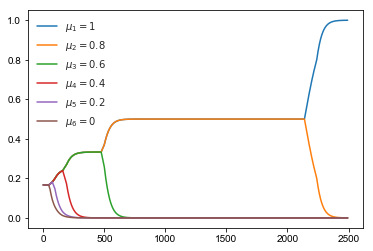

In [5]:
class ActionEliminationBanditTrial(AlgorithmBanditTrial):
    def __init__(self, bandits):
        super().__init__(bandits)
            
    def run_trial(self, time_steps=500):
        current_epoch = 0
        active_bandits_for_epoch = self.active_bandit_indexes()
        for step in np.arange(0,time_steps):
            
            for bandit_index in active_bandits_for_epoch:
                
                self.rewards_per_arm[bandit_index].append(self.pull_arm(bandit_index))

                reference_arm = self.estimated_best_bandit_mean()
                reference_C_t = self.C_ik(reference_arm[0])

                for bandit_idx in self.active_bandit_indexes():
                    candidate_arm_mean = self.empirical_mean(bandit_idx)
                    candidate_C_t = self.C_ik(bandit_idx)
                    lhs = reference_arm[1] - reference_C_t
                    rhs = candidate_arm_mean + candidate_C_t
                    if lhs >= rhs and rhs > (-np.inf):
                        self.drop_arm(bandit_idx)

            if current_epoch > 0:
                self.pull_count_per_timestep.append([len(self.rewards_per_arm[idx]) for idx, _b in enumerate(self.bandits)])

            if step > 0 and step % (self.k - 1) == 0:
                active_bandits_for_epoch = self.active_bandit_indexes()
                current_epoch += 1

bandits = [NormalBandit(mean, SIGMA) for mean in BANDIT_MEANS]
trials = BanditTrials(bandits, n_trials=2, n_time_steps=2500)
trials.run_trials(ActionEliminationBanditTrial)

results = trials.results_as_probability()
plot_bandits(results)

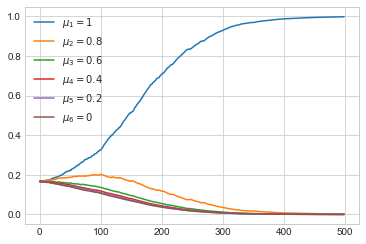

In [6]:
class UCBBanditTrial(AlgorithmBanditTrial):
    def __init__(self, bandits):
        super().__init__(bandits)
    
    def run_trial(self, time_steps=500):
        for step in np.arange(0,time_steps):

            # check to see if we haven't sampled a bandit yet:
            unexplored = np.where(np.isinf(self.all_empirical_means()))[0]

            if len(unexplored) != 0:
                best_bandit_index = unexplored[0]
            
            else:
                best_bandit_index, results = self.best_filtered_bandit_index_with_C_ik(np.arange(0, self.bandit_count))
               
                h,l = self.get_h_and_l()
                
                lhs = h.mean - self.C_ik(h.index)
                rhs = l.mean + self.C_ik(l.index)
                
                if lhs > rhs:
                    self.print_stopping_condition(step)
                    break                

            self.rewards_per_arm[best_bandit_index].append(self.pull_arm(best_bandit_index))
            self.pull_count_per_timestep.append([len(self.rewards_per_arm[idx]) for idx, _b in enumerate(self.bandits)])

            
bandits = [NormalBandit(mean, SIGMA) for mean in BANDIT_MEANS]
trials = BanditTrials(bandits, n_trials=5, n_time_steps=500)
trials.run_trials(UCBBanditTrial)

results = trials.results_as_probability()
plot_bandits(results)

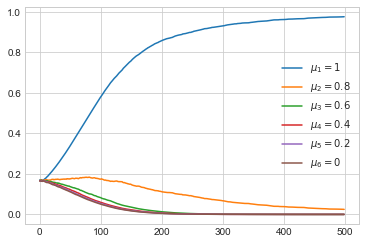

In [7]:
class LUCBBanditTrial(AlgorithmBanditTrial):
    def __init__(self, bandits):
        super().__init__(bandits)
    
    def run_trial(self, time_steps=500):
        for step in np.arange(0,time_steps):

            # check to see if we haven't sampled a bandit yet:
            unexplored = np.where(np.isinf(self.all_empirical_means()))[0]

            if len(unexplored) != 0:
                # grab the next one:
                arm = unexplored[0]
                self.rewards_per_arm[arm].append(self.pull_arm(arm))
            
            else:
                h,l = self.get_h_and_l()                
                lhs = h.mean - self.C_ik(h.index)
                rhs = l.mean + self.C_ik(l.index)
                if lhs > rhs:
                    self.print_stopping_condition(step)
                    break                

                self.rewards_per_arm[h.index].append(self.pull_arm(h.index))
                self.rewards_per_arm[l.index].append(self.pull_arm(l.index))
        
            self.pull_count_per_timestep.append([len(self.rewards_per_arm[idx]) for idx, _b in enumerate(self.bandits)])
            
bandits = [NormalBandit(mean, SIGMA) for mean in BANDIT_MEANS]
trials = BanditTrials(bandits, n_trials=5, n_time_steps=500)
trials.run_trials(LUCBBanditTrial)

results = trials.results_as_probability()
plot_bandits(results)

(c) Perform the same empirical comparison on the bandit problem provided in the Sutton & Barto book (which we discussed in class). Do not forget to average your results over multiple independent runs.

In [8]:
class BanditMachine(object):
    def __init__(self, k):
        self.k = k
        self.q_star = np.random.normal(0,1,k)
        self.q_star_variance = 1.0

    def pull_arm(self, arm):
        assert 0 <= arm < self.k
        return np.random.normal(self.q_star[arm], self.q_star_variance)

    def optimal_action(self):
        return np.argmax(self.q_star)
    
class AlgorithmBandit:
    def __init__(self, k, initial_value=0):
        self.k = k
        self.N = np.zeros(k)
        self.Q = np.zeros(k) + initial_value
        self.t = 0
        self.rewards=[]
        self.actions=[]
        self.regrets=[]

    def policy(self):
        pass
    
    def update_N_Q(self, A, R):
        self.N[A] += 1
        self.Q[A] += (R - self.Q[A]) / self.N[A]
        
    def record(self, bandit_machine, A, R):
        self.actions.append(A)
        self.rewards.append(R)
        self.regrets.append(bandit_machine.q_star[bandit_machine.optimal_action()] - R)

    def take_action(self, bandit_machine):
        set_A = self.policy()
        for A in set_A:
            self.t += 1
            R = bandit_machine.pull_arm(A)
            self.update_N_Q(A, R)
            
            self.record(bandit_machine, A, R)

In [9]:
class EpsilonGreedy(AlgorithmBandit):
    def __init__(self, k, epsilon=0, initial_value=0):
        super().__init__(k, initial_value)
        self.epsilon = epsilon

    def policy(self):
        if np.random.rand() < 1 - self.epsilon:
            return [np.argmax(self.Q)]
        else:
            return [np.random.randint(0, self.k)]

In [10]:
class OptimisticGreedy(EpsilonGreedy):
    def __init__(self, k, initial_value=0):
        super().__init__(k, epsilon=0, initial_value=initial_value)

In [11]:
class UpperConfidenceBound1(AlgorithmBandit):
    def __init__(self, k, c=1, initial_value=0):
        super().__init__(k, initial_value)
        self.c = c  # degree of exploration

    def policy(self):
        never_tried = np.where(self.N == 0)[0]
        if never_tried.any():
            return [never_tried[0]]
        return [np.argmax(self.Q + self.c * np.sqrt(np.log(self.t) / self.N))]

In [12]:
def softmax(x, axis=0):
    e_x = np.exp(x - np.max(x, axis=axis))
    return e_x / np.sum(e_x, axis=axis)
class GradientAscent(AlgorithmBandit):
    def __init__(self, k, step_size=0.125, initial_value=0):
        super().__init__(k, initial_value)
        self.H = np.zeros(k)  # preference of each action
        self.step_size = step_size  # learning rate
        self.base_line = 0  # choose baseline = average of all reward
      
    def take_action(self, bandit_machine):
        self.t += 1
        policy = softmax(self.H)
        A = np.random.choice(self.k, p=policy)
        R = bandit_machine.pull_arm(A)

        for i in range(self.k):
            if i == A:
                self.H[i] += self.step_size * (R - self.base_line) * (1 - policy[i])
            else:
                self.H[i] -= self.step_size * (R - self.base_line) * policy[i]

        self.base_line += (R - self.base_line) / self.t
        
        self.record(bandit_machine, A, R)

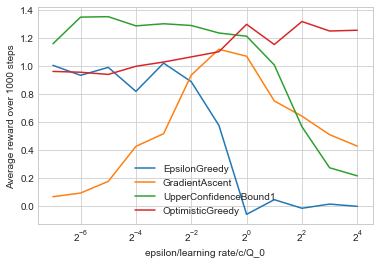

In [13]:
def parameter_study(param, type_algo, k=10, nb_test=100, nb_step = 100):
    rewards = np.zeros((len(param), nb_test, nb_step))
    for i in range(len(param)):
        for j in range(nb_test):
            algo = type_algo(k, param[i])
            bandit = BanditMachine(k)
            for n in range(nb_step):
                algo.take_action(bandit)
            rewards[i,j,:] = algo.rewards

    return np.mean(np.mean(rewards, axis=1), axis=1)


nb_test = 100
nb_step = 100
k=10

param = [2**i for i in range(-7, 5, 1)]
algos = [EpsilonGreedy, 
         GradientAscent, 
         UpperConfidenceBound1,
         OptimisticGreedy]

parameter_study_values={}
for algo in algos:
    parameter_study_values[algo.__name__] = parameter_study(param, algo, k, nb_test, nb_step)
    
####### PLOT

for algo_name in parameter_study_values:
    plt.plot(param, parameter_study_values[algo_name], label=algo_name)
plt.xscale("log", basex=2)
plt.xlabel("epsilon/learning rate/c/Q_0")
plt.ylabel("Average reward over 1000 steps")
plt.legend()
plt.show()

(d) Discuss in a short paragraph a concrete application in which you think regret optimization would be more useful than best arm identification

# Markov Decision Processes and dynamic programming
I choosed option (a)

In [22]:
%load_ext autoreload
%autoreload 2

import mdp

In [45]:
mdp.hyperparameter_testing(world_size=5, p_desired_direction=0.7, gamma=0.9, epsilon=1e-5)

HYPER PARAMETERS
world_size :  5
p_desired_direction :  0.7
gamma :  0.9
epsilon :  1e-05


POLICY ITERATION 
Policy found in 4 iterations, where each policy evaluation lasted for k = [64, 31, 24, 13]

V
 [[0.  6.6 8.1 9.5 0. ]
 [5.  6.1 7.1 8.2 9.5]
 [4.6 5.3 6.2 7.1 8.1]
 [4.1 4.6 5.3 6.2 7. ]
 [3.6 4.1 4.7 5.4 6. ]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑


Testing
Bottom left. V : 3.643568312490081 True :  3.699829727274974
Bottom right. V : 6.028786575785032 True :  5.754603946291829
[0.8 0.  0.  0. ] [0.8 0.1 0.1 0.1]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0.  0.  0.8 0. ] [0.8 0.8 7.8 0.8]
[0.  0.8 0.  0. ] [0.1 0.8 0.1 0.1]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0.  0.8 0.  0. ] [0.8 7.8 0.8 0.8]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0. 0. 0. 0.] [0. 0. 0. 0.]
[0. 

[0.1 0.2 2.  0.1] [1.7 2.5 2.5 1.7]
[0.1 2.5 0.3 0.2] [1.9 3.1 3.2 2.6]
[0.2 3.4 0.3 0.3] [2.9 4.2 4.2 3.5]
[0.3 0.4 0.4 3.4] [3.7 5.  5.  4.5]
[3.4 0.5 0.4 0.4] [4.7 5.9 5.2 5.2]
[0.8 0.4 0.5 0.4] [2.2 5.6 6.5 5.2]
[4.5 0.5 0.6 0.5] [6.2 7.2 8.1 6.5]
[0.5 0.6 0.8 5.7] [7.6 8.5 9.5 7.7]
[0.3 0.8 0.4 0.3] [4.  1.8 4.8 3.7]
[0.3 0.4 4.9 0.3] [4.5 5.7 6.  4.7]
[0.4 5.6 0.6 0.4] [5.7 7.  7.1 5.7]
[0.5 0.6 6.6 0.5] [6.7 8.2 8.2 6.7]
[5.7 0.8 0.6 0.5] [7.7 9.5 8.5 7.6]
[2.9 0.3 0.3 0.2] [3.8 4.1 4.3 3.1]
[2.9 0.4 0.4 0.3] [4.  5.1 5.2 4. ]
[0.3 0.5 4.9 0.3] [4.7 6.  6.1 4.8]
[4.2 0.6 0.5 0.4] [5.7 7.1 7.  5.7]
[0.5 6.6 0.5 0.5] [6.6 8.1 7.2 6.4]
[0.2 2.9 0.3 0.2] [2.9 3.6 3.5 2.5]
[0.2 0.3 0.3 2.2] [3.1 4.2 4.2 3.1]
[0.3 0.4 0.4 2.9] [4.  5.2 5.2 4. ]
[3.5 0.5 0.5 0.3] [4.7 6.  5.9 4.8]
[0.4 0.5 0.5 4.1] [5.6 6.9 6.1 5.5]
[0.2 0.2 2.2 0.2] [2.3 2.7 2.8 2.3]
[0.2 2.9 0.3 0.2] [2.5 3.6 3.6 3. ]
[0.2 3.5 0.3 0.3] [3.2 4.3 4.4 3.8]
[0.3 0.4 0.4 3.5] [4.1 5.2 5.1 4.6]
[3.5 0.5 0.4 0.4] [4.8 5.9 5

[0.3 0.4 0.4 3.3] [4.4 5.3 5.3 4.4]
[3.7 0.5 0.5 0.4] [5.  6.2 6.1 5.1]
[0.4 0.5 0.5 4.2] [5.7 7.  6.2 5.6]
[0.2 0.3 2.9 0.2] [3.3 3.6 3.6 3.3]
[0.2 3.2 0.3 0.3] [3.4 4.1 4.1 3.7]
[0.3 3.7 0.4 0.3] [3.9 4.7 4.7 4.3]
[0.3 0.4 0.4 3.8] [4.5 5.4 5.3 4.9]
[3.8 0.5 0.4 0.4] [5.  6.  5.4 5.4]
[0.8 0.4 0.5 0.4] [2.2 5.6 6.6 5.3]
[4.6 0.5 0.6 0.5] [6.3 7.2 8.1 6.6]
[0.5 0.6 0.8 5.7] [7.6 8.5 9.5 7.7]
[0.3 0.8 0.4 0.3] [4.3 1.8 5.  4.1]
[0.3 0.4 5.  0.4] [4.8 5.8 6.1 5. ]
[0.4 5.6 0.6 0.4] [5.8 7.  7.1 5.8]
[0.5 0.6 6.6 0.5] [6.7 8.2 8.2 6.7]
[5.7 0.8 0.6 0.5] [7.7 9.5 8.5 7.6]
[3.2 0.3 0.4 0.3] [4.2 4.4 4.6 3.8]
[3.2 0.4 0.4 0.3] [4.4 5.3 5.3 4.4]
[0.4 0.5 5.  0.4] [5.  6.2 6.2 5. ]
[4.3 0.6 0.5 0.4] [5.8 7.1 7.1 5.8]
[0.5 6.6 0.5 0.5] [6.6 8.1 7.3 6.5]
[0.3 3.2 0.3 0.2] [3.7 4.1 4.1 3.4]
[0.3 0.4 0.4 2.9] [3.8 4.6 4.6 3.9]
[0.3 0.4 0.4 3.3] [4.4 5.3 5.3 4.4]
[3.7 0.5 0.5 0.4] [5.  6.2 6.1 5.1]
[0.4 0.5 0.5 4.2] [5.7 7.  6.2 5.6]
[0.2 0.3 2.9 0.2] [3.3 3.6 3.6 3.3]
[0.2 3.2 0.3 0.3] [3.4 4.1 4

In [28]:
mdp.hyperparameter_testing(world_size=5, p_desired_direction=0.9, gamma=0.9, epsilon=1e-5)

HYPER PARAMETERS
world_size :  5
p_desired_direction :  0.9
gamma :  0.9
epsilon :  1e-05


POLICY ITERATION 
Policy found in 5 iterations, where each policy evaluation lasted for k = [79, 20, 13, 6, 2]

V
 [[0.  7.6 8.8 9.9 0. ]
 [6.1 7.  7.8 8.8 9.9]
 [5.5 6.2 7.  7.8 8.8]
 [5.  5.5 6.2 7.  7.8]
 [4.4 5.  5.6 6.2 6.9]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑


Testing
Bottom left. V : 4.443413770979517 True :  4.40326640543778
Bottom right. V : 6.931096096614802 True :  6.89672637


MODIFIED POLICY ITERATION 
Policy found in 6 iterations, where each policy evaluation lasted for k = [2, 2, 2, 2, 2, 2]

V
 [[0.  7.6 8.8 9.9 0. ]
 [6.1 7.  7.8 8.8 9.9]
 [5.5 6.2 7.  7.8 8.8]
 [4.9 5.5 6.2 7.  7.8]
 [4.3 4.9 5.5 6.2 6.9]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑


Testing
Bottom left. V : 4.274341391564207 True :  4.40986785925158
Bottom right. V : 6.928869684481775 True :  6.930690479999999


VALUE ITERATION
Policy found in 19 iterations

V
 [[0.  7.6 8.8 9.9 0. ]
 [6.1 7.  7.8 8.8 9.9]
 [5.5 6.2 7.

In [29]:
mdp.hyperparameter_testing(world_size=50, p_desired_direction=0.7, gamma=0.9, epsilon=1e-5)

HYPER PARAMETERS
world_size :  50
p_desired_direction :  0.7
gamma :  0.9
epsilon :  1e-05


POLICY ITERATION 
Policy found in 18 iterations, where each policy evaluation lasted for k = [68, 103, 70, 52, 46, 22, 17, 18, 17, 12, 1, 1, 1, 1, 1, 1, 1, 1]

V
 [[0.  0.9 0.8 ... 8.1 9.5 0. ]
 [0.9 0.8 0.7 ... 7.1 8.2 9.5]
 [0.8 0.7 0.6 ... 6.2 7.1 8.1]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]

PI
■←←←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→■
↑←←←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑
↑↑←←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑
↑↑↑←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑
↑↑↑↑↑←←←←←←←←←←←↑→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑
↑↑↑↑↑↑←←←←←←←←←←↑↑→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑
↑↑↑↑↑↑↑←←←←←←←←↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑
↑↑↑↑↑↑↑↑←←←←←←↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑←←←←↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑←↑↑↑↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑→↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑→→→→→→↑↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑←←←↑↑↑↑↑↑↑↑↑↑↑↑→→→→→→→→→↑↑↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑←←←←←←←↑↑↑↑↑↑↑↑↑→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑←←←←←←←←←←←↑↑↑↑↑→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑←←←←←←←←←←←←←←↑↑→→→→→→→→

In [ ]:
mdp.hyperparameter_testing(world_size=50, p_desired_direction=0.9, gamma=0.9, epsilon=1e-5)